# Importing all the necessary libraries

In [1]:
# basic libraries
import copy
import os
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libraries for the model training and dataset loading
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from transformers import get_scheduler
import torch
from torch.utils.data import Dataset, DataLoader

# LoRA library from Microsoft (https://github.com/microsoft/LoRA/tree/main)
import loralib

# files with custom Bert model and the changed file from transformers library
import bert_multi_lora
from custom_model import CustomBert, LoRABert

C:\Users\balanton\anaconda3\envs\semester_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# uncomment the below line if you want to automatically reload the modules
# though this will disable debugging in the notebook

# %load_ext autoreload
# %autoreload 2

# Masking

In [3]:
# setting device to `cuda` if gpu exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
# initialising the model
# bert = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
# bert = BertPreTrainedModel_masking.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

# model is initialized from the custom file since it has the masking functionality
bert = bert_multi_lora.BertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

## Sizes comparison

In this section we compare the sizes of the custom implementation of the model with multiple adapters, and the [LoRA implementation from Microsoft](https://github.com/microsoft/LoRA/tree/main). The sizes are compared for the model with different number of adapters.

In [5]:
def get_size_of_model(model):
    """
    Function to get the size of the model. It calculates the size by adding all the parameters and buffers of the model.
    
    :param model: model for which the size is to be calculated 
    :return: size of the model in MB
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    return (param_size + buffer_size) / 1024**2

def get_sizes(max_adapters=5):
    """
    Function to get the sizes of the models with different number of adapters.
    
    :param max_adapters: maximum number of adapters to be considered
    :return: 2 dataframes: on with the size of the model with custom adapters and the other with the size of the model with LoRA adapters
    """
    sizes = []
    sizes_full = []
    
    sizes.append({"model": "bert", "size": get_size_of_model(bert)})
    sizes_full.append({"model": "bert", "size": get_size_of_model(bert)})
    
    for i in range(1, max_adapters + 1):
        model_custom = CustomBert(copy.deepcopy(bert), num_adapters=i)
        models_LoRA = [LoRABert(copy.deepcopy(bert)) for _ in range(i)]
        
        sizes.append({"model": f"{i} adapters", "size": get_size_of_model(model_custom)})
        sizes_full.append({"model": f"{i} adapters", "size": sum([get_size_of_model(model) for model in models_LoRA])})
        
    return pd.DataFrame(sizes), pd.DataFrame(sizes_full)

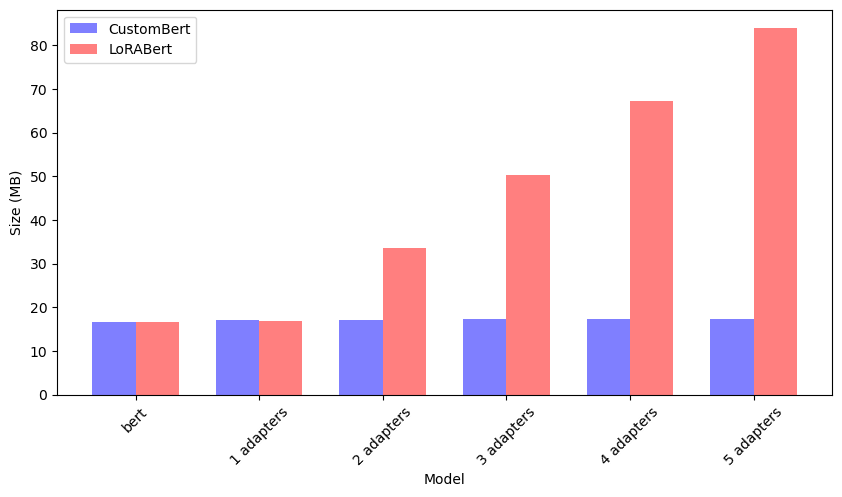

In [6]:
# Get the sizes of the models with different number of adapters (up to 5 adapters)
df_custom, df_LoRA = get_sizes(5)

def plot_sizes(df_1, df_2):
    """
    Function to plot the sizes of the models with different number of adapters.
    
    :param df_1: dataframe with the sizes of the model with custom adapters
    :param df_2: dataframe with the sizes of the model with LoRA adapters
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    index = np.arange(len(df_1))
    bar_width = 0.35

    opacity = 0.5

    ax.bar(index, df_1["size"], bar_width, alpha=opacity, color='b', label='CustomBert')
    ax.bar(index + bar_width, df_2["size"], bar_width, alpha=opacity, color='r', label='LoRABert')

    ax.legend()
    ax.set_ylabel("Size (MB)")
    ax.set_xlabel("Model")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(df_1["model"], rotation=45)
    plt.show()
    
    
plot_sizes(df_custom, df_LoRA)

As we can see from the plot above, the size of the model with custom adapters is significantly smaller than the size of the model with LoRA adapters. This is because the custom implementation only adds the adapters to the model, while the LoRA implementation adds the full model for each adapter.

## Custom model finetuning

### Dataset and Dataloaders

In [7]:
class MultiAdapterDataset(Dataset):
    """
    Dataset class for the custom dataset that will be used for training and evaluation.
    """
    
    def __init__(self, datasets, lora_cnt=2, id=None):
        """
        Constructor for the class.
        
        :param datasets: datasets that will be used to train and evaluate respective adapters
        :param lora_cnt: number of adapters
        :param id: id of the adapter (& dataset) that will be used for the evaluation. If None, the dataset is used for training
        """
        self.datasets = datasets
        self.id = id
        self.lora_cnt = lora_cnt

    def __len__(self):
        """
        Function to get the length of the dataset.
        
        :return: length of the dataset. If id is not None, the length of the dataset with the given id is returned, otherwise the sum of the lengths of all datasets is returned
        """
        if self.id is not None:
            return len(self.datasets[0])
        else:
            return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        """
        Function to get the item from the dataset.
        
        :param idx: index of the item
        :return: item from the dataset. If id is not None, the item from the dataset with the given id is returned, otherwise the item from the dataset with the index (idx % lora_cnt) is returned
        """
        
        # masking is used to determine which adapter is used for the given item, it is 1 for the adapter that is used and 0 for the other adapters
        masking = torch.zeros(self.lora_cnt)
        
        if self.id is not None:
            masking[self.id] = 1
            d = self.datasets[0][idx]
        else:
            masking[idx % self.lora_cnt] = 1
            d = self.datasets[idx % self.lora_cnt][idx // self.lora_cnt]
        
        ids = torch.tensor(d['input_ids'])
        mask = torch.tensor(d['attention_mask'])
        label = torch.tensor(d['label'])
        
        return ids, mask, label, masking

In [8]:
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

# here we define the tokenization functions for the datasets, different functions are used for different datasets as the structure of the datasets is different
def tokenize_imdb(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_sst2(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

def tokenize_amazon(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=128)


def get_tokenized_datasets(paths, functions, split="train", batched=True, num_samples=1000):
    """
    Function to get the tokenized datasets.
    
    :param paths: paths to the datasets, can be local paths or the names of the datasets from the Hugging Face library
    :param functions: functions that will be used to tokenize the datasets
    :param split: split of the dataset that will be used, can be "train" or "test"
    :param batched: whether the tokenization should be batched
    :param num_samples: number of samples that will be used from each dataset
    :return: list of tokenized datasets
    """
    datasets = [load_dataset(path) for path in paths]
    tokenized_datasets = [dataset.map(function, batched=batched)[split].shuffle(seed=42).select(range(num_samples)) for dataset, function in zip(datasets, functions)]
    return tokenized_datasets

def get_dataloaders(tokenized_datasets, lora_cnt, split="train", batch_size=8):
    """
    Function to get the dataloaders for the datasets.
    
    :param tokenized_datasets: tokenized datasets
    :param lora_cnt: number of adapters
    :param split: split of the dataset that will be used, can be "train" or "test"
    :param batch_size: batch size
    :return: list of dataloaders
    """
    # if the split is "train", only one dataloader is returned, otherwise a list of dataloaders is returned
    if split=="train":
        dataset = MultiAdapterDataset(tokenized_datasets, lora_cnt=lora_cnt)
        return DataLoader(dataset, shuffle=True, batch_size=batch_size)
    elif split=="test":
        datasets = [MultiAdapterDataset([tokenized_datasets[i]], lora_cnt=lora_cnt, id=i) for i in range(lora_cnt)]
        return [DataLoader(dataset, shuffle=False, batch_size=batch_size) for dataset in datasets]
    else:
        raise ValueError("Invalid split")

### Defining the model

In [9]:
# Define LoRA parameters
num_adapters = 2
rank = 8
alpha = 32

# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters, rank=rank, alpha=alpha).to(device)

### Initial evaluation

In [10]:
tokenized_test = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

In [11]:
# Evaluate both adapters on respective datasets
model.eval()
criterion = torch.nn.BCELoss()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6912490668296813
Adapter 1 loss: 0.7051456623077392


### Training

In [12]:
tokenized_datasets = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="train")

In [13]:
# Training loop
model.train()
criterion = torch.nn.BCELoss()

optimizer = AdamW(model.parameters(), lr=5e-5)  

train_dataloader = get_dataloaders(tokenized_datasets, num_adapters, split="train")

num_epochs = 200
num_training_steps = num_epochs

lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Mark only LoRA parameters as trainable
for name, param in model.named_parameters():
    if "adapters" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [14]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.query.linear.weight False
bert.encoder.layer.0.attention.self.query.linear.bias False
bert.encoder.layer.0.attention.self.query.adapters.0.weight True
bert.encoder.layer.0.attention.self.query.adapters.0.lora_A True
bert.encoder.layer.0.attention.self.query.adapters.0.lora_B True
bert.encoder.layer.0.attention.self.query.adapters.1.weight True
bert.encoder.layer.0.attention.self.query.adapters.1.lora_A True
bert.encoder.layer.0.attention.self.query.adapters.1.lora_B True
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.key.linear.weight F

In [15]:
# initialising the dictionary with the parameters of the adapters for faster access
parameters_dict = {}
for i in range(num_adapters):
    parameters_dict[str(i)] = []
    
for name, param in model.named_parameters():
    if "adapters" in name:
        parameters_dict[name.split(".")[-2]].append(param)

In [16]:
start = time.time()

for epoch in tqdm.tqdm(range(num_epochs)):
    for batch in train_dataloader:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        
        # for name, param in model.named_parameters():
        #     if "adapters" in name:
        #         param.requires_grad = False
        
        for key, params in parameters_dict.items():
            for param in params:
                param.requires_grad = False

        for i in range(num_adapters):
            # for name, param in model.named_parameters():
            #     if "bert.encoder.layer.0.attention.self.value.adapters.0.lora_A" in name:
            #         print(i, param.grad)
            
            # for name, param in model.named_parameters():
            #     if f"adapters.{i}" in name:
            #         param.requires_grad = True
            
            params = parameters_dict[str(i)]
            for param in params:
                param.requires_grad = True
            
            o_adapter = o.view(-1, num_adapters).t()[i]
            labels_adapter = labels.view(-1, num_adapters).t()[i]
            loss = criterion(o_adapter, labels_adapter.to(device))
                       
            loss.backward(retain_graph=True)
            
            # for name, param in model.named_parameters():
            #     if "bert.encoder.layer.0.attention.self.value.adapters.0.lora_A" in name:
            #         print(i, param.grad)
                    
            # for name, param in model.named_parameters():
            #     if "adapters" in name:
            #         param.requires_grad = False

            for param in params:
                param.requires_grad = False
                    
            
        # for name, param in  model.named_parameters():
        #     if "adapters" in name:
        #         param.requires_grad = True    
        
        for key, params in parameters_dict.items():
            for param in params:
                param.requires_grad = True

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        
print(f"Training time: {time.time() - start}")

100%|██████████| 200/200 [12:58<00:00,  3.89s/it]

Training time: 778.3863773345947


### Evaluation

In [17]:
tokenized_test = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

In [18]:
# Evaluate both adapters on respective datasets
model.eval()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6906183857917786
Adapter 1 loss: 0.7006991996765136


### Saving the model

In [19]:
# save the tokenizer and the model in `./test-model/` directory 
tokenizer.save_pretrained("./test-model/")
model.save_pretrained("./test-model/", push_to_hub=False)

## LoRA model finetuning

In [20]:
bert_normal = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
loraBerts = [LoRABert(copy.deepcopy(bert_normal)).to(device) for _ in range(num_adapters)]

# Mark only LoRA parameters as trainable
loralib.utils.mark_only_lora_as_trainable(loraBerts[0])
loralib.utils.mark_only_lora_as_trainable(loraBerts[1])

### Initial evaluation

In [21]:
tokenized_test = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

for i in range(num_adapters):
    loraBerts[i].eval()
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, _ = batch
        labels = labels.type(torch.float)
        o = loraBerts[i](ids.to(device), masks.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6974962949752808
Adapter 1 loss: 0.7837476348876953


### Training

In [22]:
# Training loop
loraBerts[0].train()
loraBerts[1].train()
criterion = torch.nn.BCELoss()

tokenized_datasets = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="train")
train_dataloaders = get_dataloaders(tokenized_datasets, num_adapters, split="test")

num_epochs = 200

In [23]:
start = time.time()

for i in range(num_adapters):
    optimizer = AdamW(loraBerts[i].parameters(), lr=5e-5)
    for epoch in tqdm.tqdm(range(num_epochs)):
        for batch in train_dataloaders[i]:
            ids, masks, labels, _ = batch
            labels = labels.type(torch.float)
            o = loraBerts[i](ids.to(device), masks.to(device))

            loss = criterion(torch.squeeze(o), labels.to(device))
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

print(f"Training time: {time.time() - start}")

100%|██████████| 200/200 [03:44<00:00,  1.12s/it]

Training time: 443.38819670677185


### Evaluation

In [24]:
tokenized_test = get_tokenized_datasets(["imdb", "fancyzhx/amazon_polarity"], [tokenize_imdb, tokenize_amazon], num_samples=1000, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

for i in range(num_adapters):
    loraBerts[i].eval()
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, _ = batch
        labels = labels.type(torch.float)
        o = loraBerts[i](ids.to(device), masks.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6642818409800529
Adapter 1 loss: 0.5834276948571205
